<a href="https://colab.research.google.com/github/ornenovino/python_course_eim/blob/main/intro_py_m4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introducción a la programación en python

## Módulo 4: Análisis de Texto y Webscrapping

Introducción al análisis de texto y cómo utilizar Python para realizar webscrapping.

Para este módulo utilizaremos dos librerías nuevas `requests` para realizar peticiones del tipo `GET` a un servidor donde va a estar alojada una página web y `BeautifulSoup` que nos permite acceder a los distintos `<tags>` o elementos `HTML`.

In [ ]:
import requests
from bs4 import BeautifulSoup

### Scrapping simple

In [ ]:
# Para comenzar de manera simple tomamos un URL que contiene una tabla 
# de películas alojada en IMBD

url = "https://www.imdb.com/search/title/?groups=top_1000&ref_=adv_prv" # colocamos el URL en una variable
page = requests.get(url) # hacemos un request get al servidor
soup = BeautifulSoup(page.content, 'html.parser') # salvamos el html.parser que nos permitirá acceder a los elementos del maquetado web

# con un simple comando podemos acceder y guardar los títulos de las películas
# sabíendo que los mismos son h3
movies = soup.find_all('h3', class_='lister-item-header')
movies

[<h3 class="lister-item-header">
 <span class="lister-item-index unbold text-primary">1.</span>
 <a href="/title/tt13833688/">The Whale</a>
 <span class="lister-item-year text-muted unbold">(2022)</span>
 </h3>, <h3 class="lister-item-header">
 <span class="lister-item-index unbold text-primary">2.</span>
 <a href="/title/tt11813216/">The Banshees of Inisherin</a>
 <span class="lister-item-year text-muted unbold">(2022)</span>
 </h3>, <h3 class="lister-item-header">
 <span class="lister-item-index unbold text-primary">3.</span>
 <a href="/title/tt1630029/">Avatar: The Way of Water</a>
 <span class="lister-item-year text-muted unbold">(2022)</span>
 </h3>, <h3 class="lister-item-header">
 <span class="lister-item-index unbold text-primary">4.</span>
 <a href="/title/tt6710474/">Everything Everywhere All at Once</a>
 <span class="lister-item-year text-muted unbold">(2022)</span>
 </h3>, <h3 class="lister-item-header">
 <span class="lister-item-index unbold text-primary">5.</span>
 <a hre

In [ ]:
# Creamos una lista vacía
movie_data = []

for movie in movies:  # hacemos una estructura de control que itere sobre la lista anterior movies

    # nos quedamos con el titulo y lo guardamos
    title = movie.find('a').text

    # nos quedamos con el año y lo guardamos
    year = movie.find('span', class_='lister-item-year text-muted unbold').text

    # hacemos un append de ambos valores a nuestra lista inicial
    movie_data.append((title, year))

# hacemos un print de lo que se salvo en la lista
print(movie_data)

[('The Whale', '(2022)'), ('The Banshees of Inisherin', '(2022)'), ('Avatar: The Way of Water', '(2022)'), ('Everything Everywhere All at Once', '(2022)'), ('All Quiet on the Western Front', '(2022)'), ('Puss in Boots: The Last Wish', '(2022)'), ('The Fabelmans', '(2022)'), ('Top Gun: Maverick', '(2022)'), ('Aftersun', '(II) (2022)'), ('Titanic', '(1997)'), ("Harry Potter and the Sorcerer's Stone", '(2001)'), ('The Batman', '(2022)'), ('The Shawshank Redemption', '(1994)'), ('The Godfather', '(1972)'), ('Once Upon a Time in Hollywood', '(2019)'), ('Interstellar', '(2014)'), ('Avatar', '(2009)'), ('Avengers: Endgame', '(2019)'), ('Pulp Fiction', '(1994)'), ('The Lord of the Rings: The Fellowship of the Ring', '(2001)'), ('Spider-Man: No Way Home', '(2021)'), ('Knives Out', '(2019)'), ('Whiplash', '(2014)'), ('Dune', '(2021)'), ("Guillermo del Toro's Pinocchio", '(2022)'), ('The Wolf of Wall Street', '(2013)'), ('The Dark Knight', '(2008)'), ('Inception', '(2010)'), ('The Gentlemen', '(2

### Scrapping complejo y dataframes

In [ ]:
# aquí importamos pandas
import pandas as pd

In [ ]:
# sobreescribimos variables de interes
page = requests.get("https://www.imdb.com/chart/top")
soup = BeautifulSoup(page.content, 'html.parser')

# creamos la lista vacia
movies_list = []

In [ ]:
# encontramos la tabla en la página web
tbody = soup.find('tbody', class_='lister-list')
trs = tbody.find_all('tr')  # encontramos todas las filas

for tr in trs:  # iteramos por sobre todas las filas

    # nos quedamos con el título y el año de cada película
    title = tr.find('td', class_='titleColumn').a.text
    year = tr.find('td', class_='titleColumn').span.text[1:-1]

    # guardamos el rating
    rating = float(tr.find('td', class_='ratingColumn imdbRating').strong.text)

    # hacemos append de cada una de estas variables
    movies_list.append((title, year, rating))

In [ ]:
# creamos un pandas dataframe de la lista anterior definiendo las columnas
movies_df = pd.DataFrame(movies_list, columns=['Title', 'Year', 'Rating'])

# incluso lo podemos salvar como un CSV
movies_df.to_csv('imdb-movies-dataset.csv', index = False)

In [ ]:
# podemos echar un vistazo del df que acabamos de crear
movies_df.head()

,Title,Year,Rating
0,The Shawshank Redemption,1994,9.2
1,The Godfather,1972,9.2
2,The Dark Knight,2008,9.0
3,The Godfather Part II,1974,9.0
4,12 Angry Men,1957,9.0


### Análisis de texto

**Nube de palabras**

In [ ]:
# importamos las librerías
import nltk 
from nltk.tokenize import word_tokenize 
nltk.download('punkt')
from wordcloud import WordCloud
import matplotlib.pyplot as plt

ed_sheeran =  pd.read_csv('/content/drive/MyDrive/python_intro/EdSheeran.csv', encoding="utf-8")
ed_sheeran.head()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Unnamed: 0,Artist,Title,Album,Year,Date,Lyric
0,0,Ed Sheeran,Shape of You,÷ (Divide),2017.0,2017-01-06,the club isn't the best place to find a lover so the bar is where i go me and my friends at the table doing shots drinking fast and then we talk slow and you come over and start up a conversation with just me and trust me i'll give it a chance now take my hand stop put van the man on the jukebox and then we start to dance and now i'm singing like pre girl you know i want your love your love was handmade for somebody like me come on now follow my lead i may be crazy don't mind me say boy let's not talk too much grab on my waist and put that body on me come on now follow my lead come come on now follow my lead i'm in love with the shape of you we push and pull like a magnet do although my heart is falling too i'm in love with your body and last night you were in my room and now my bed sheets smell like you every day discovering something brand new i'm in love with your body ohiohiohiohi i'm in love with your body ohiohiohiohi i'm in love with your body ohiohiohiohi i'm in love with your body every day discovering something brand new i'm in love with the shape of you one week in we let the story begin we're going out on our first date you and me are thrifty so go all you can eat fill up your bag and i fill up a plate we talk for hours and hours about the sweet and the sour and how your family is doing okay leave and get in a taxi then kiss in the backseat tell the driver make the radio play and i'm singing like pre girl you know i want your love your love was handmade for somebody like me come on now follow my lead i may be crazy don't mind me say boy let's not talk too much grab on my waist and put that body on me come on now follow my lead come come on now follow my lead i'm in love with the shape of you we push and pull like a magnet do although my heart is falling too i'm in love with your body and last night you were in my room and now my bed sheets smell like you every day discovering something brand new i'm in love with your body ohiohiohiohi i'm in love with your body ohiohiohiohi i'm in love with your body ohiohiohiohi i'm in love with your body every day discovering something brand new i'm in love with the shape of you come on be my baby come on come on be my baby come on come on be my baby come on come on be my baby come on come on be my baby come on come on be my baby come on come on be my baby come on come on be my baby come on i'm in love with the shape of you we push and pull like a magnet do although my heart is falling too i'm in love with your body last night you were in my room and now my bed sheets smell like you every day discovering something brand new i'm in love with your body come on be my baby come on come on be my baby come on i'm in love with your body come on be my baby come on come on be my baby come on i'm in love with your body come on be my baby come on come on be my baby come on i'm in love with your body every day discovering something brand new i'm in love with the shape of you
1,1,Ed Sheeran,Perfect,÷ (Divide),2017.0,2017-03-03,i found a love for me oh darling just dive right in and follow my lead well i found a girl beautiful and sweet oh i never knew you were the someone waiting for me 'cause we were just kids when we fell in love not knowing what it was i will not give you up this time but darling just kiss me slow your heart is all i own and in your eyes you're holding mine baby i'm dancing in the dark with you between my arms barefoot on the grass listening to our favourite song when you said you looked a mess i whispered underneath my breath but you heard it darling you look perfect tonight well i found a woman stronger than anyone i know she shares my dreams i hope that someday i'll share her home i found a love to carry more than just my secrets to carry love to carry children of our own we are still kids but we're so in love fighting against all odds i know we'll be alright this tim

In [ ]:
# Vamos a tomar la letra de la canción Shape of You
pd.set_option('display.max_colwidth', None)
shape_of_you = ed_sheeran[ed_sheeran['Title'] == 'Shape of You']
lyrics = shape_of_you['Lyric'].to_string()
type(lyrics)

str

In [ ]:
# Tokenizing la letra por palabra
tokens = word_tokenize(lyrics)

# Creamos una distrbución simple de las palabras
freq_dist = nltk.FreqDist(tokens) 
  
# Mostramos las 5 palabras más frecuentes en la letra
print(freq_dist.most_common(5))

[('on', 40), ('come', 37), ('my', 33), ('i', 30), ('in', 27)]


Como notamos la letra contiene un montón de conectores que se deberían de eliminar.

In [ ]:
from nltk.corpus import stopwords
import string
nltk.download('stopwords')

# removemos puntuación
remove_punctuation = [char for char in lyrics if char not in string.punctuation] 

# agregamos de nuevo a la lista sin puntuación
remove_punctuation = ''.join(remove_punctuation) 

# Removemos las conocidas 'stopwords'
stop_words = set(stopwords.words('english')) 

# hacemos la tokenización nuevamente
word_tokens = word_tokenize(remove_punctuation) 

# realizamos un condicional como list comprehension
filtered_sentence = [w for w in word_tokens if not w in stop_words]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
print(len(tokens))
print(len(filtered_sentence)) # redujimos hasta la mitad las palabras
filtered_sentence

669
323


['0',
 'club',
 'isnt',
 'best',
 'place',
 'find',
 'lover',
 'bar',
 'go',
 'friends',
 'table',
 'shots',
 'drinking',
 'fast',
 'talk',
 'slow',
 'come',
 'start',
 'conversation',
 'trust',
 'ill',
 'give',
 'chance',
 'take',
 'hand',
 'stop',
 'put',
 'van',
 'man',
 'jukebox',
 'start',
 'dance',
 'im',
 'singing',
 'like',
 'pre',
 'girl',
 'know',
 'want',
 'love',
 'love',
 'handmade',
 'somebody',
 'like',
 'come',
 'follow',
 'lead',
 'may',
 'crazy',
 'dont',
 'mind',
 'say',
 'boy',
 'lets',
 'talk',
 'much',
 'grab',
 'waist',
 'put',
 'body',
 'come',
 'follow',
 'lead',
 'come',
 'come',
 'follow',
 'lead',
 'im',
 'love',
 'shape',
 'push',
 'pull',
 'like',
 'magnet',
 'although',
 'heart',
 'falling',
 'im',
 'love',
 'body',
 'last',
 'night',
 'room',
 'bed',
 'sheets',
 'smell',
 'like',
 'every',
 'day',
 'discovering',
 'something',
 'brand',
 'new',
 'im',
 'love',
 'body',
 'ohiohiohiohi',
 'im',
 'love',
 'body',
 'ohiohiohiohi',
 'im',
 'love',
 'body',
 '

In [ ]:
freq_dist_clean = nltk.FreqDist(filtered_sentence)
print(freq_dist_clean.most_common(5)) # cambian completamente las palabras más frecuentes

[('come', 37), ('love', 25), ('im', 23), ('body', 17), ('baby', 14)]


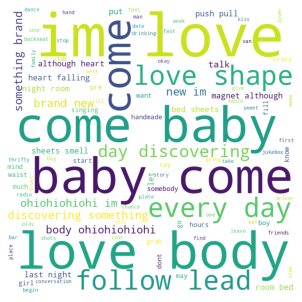

In [ ]:
# podemos generar una nube de palabras
wordcloud = WordCloud(width = 800, 
                      height = 800,
                      background_color ='white', 
                      min_font_size = 10).generate(" ".join(filtered_sentence)) 

# realizamos un plot de la misma
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show()

**Sentimientos**

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
filtered_to_string = " ".join(filtered_sentence)
filtered_to_string

'0 club isnt best place find lover bar go friends table shots drinking fast talk slow come start conversation trust ill give chance take hand stop put van man jukebox start dance im singing like pre girl know want love love handmade somebody like come follow lead may crazy dont mind say boy lets talk much grab waist put body come follow lead come come follow lead im love shape push pull like magnet although heart falling im love body last night room bed sheets smell like every day discovering something brand new im love body ohiohiohiohi im love body ohiohiohiohi im love body ohiohiohiohi im love body every day discovering something brand new im love shape one week let story begin going first date thrifty go eat fill bag fill plate talk hours hours sweet sour family okay leave get taxi kiss backseat tell driver make radio play im singing like pre girl know want love love handmade somebody like come follow lead may crazy dont mind say boy lets talk much grab waist put body come follow l

In [ ]:
# Creamos una función para analizar los sentimientos

def sentiment_scores(sentence):
 
    # Creamos un objeto del tipo SentimentIntensityAnalyze
    sid_obj = SentimentIntensityAnalyzer()
 
    # usamos el método polarity_scores del SentimentIntensityAnalyzer
    # que nos da un diccionario de sentimientos
    # que contiene pos (positivos) neg (negativos) neu(neutros) y los el score
    # el compound es la suma de los positivos, negativos y neutrales
    # normalizado entre -1 extremo negativo y +1 extremo positivo
    
    sentiment_dict = sid_obj.polarity_scores(sentence)
     
    print("Los scores son: ", sentiment_dict)
    print("La letra fue un ", sentiment_dict['neg']*100, "% Negativa")
    print("La letra fue un  ", sentiment_dict['neu']*100, "% Neutral")
    print("La letra fue un  ", sentiment_dict['pos']*100, "% Positiva")
 
    print("Entonces la canción es", end = " ")
 
    # imprimimos el resultado de acuerdo a donde caiga el número
    if sentiment_dict['compound'] >= 0.05 :
        print("Positiva")
 
    elif sentiment_dict['compound'] <= - 0.05 :
        print("Negativa")
 
    else :
        print("Neutral")

In [ ]:
sentiment_scores(filtered_to_string)

Los scores son:  {'neg': 0.043, 'neu': 0.601, 'pos': 0.356, 'compound': 0.9993}
La letra fue un  4.3 % Negativa
La letra fue un   60.099999999999994 % Neutral
La letra fue un   35.6 % Positiva
Entonces la canción es Positiva


### Ejercicios

In [ ]:
# 1. Analizar los raitings de las 250 películas scrapeadas

In [ ]:
# 2. ¿Cuántas películas tienen un rating mayor a 8?

In [ ]:
# 3. Realizar un gráfico de línea por año con cantidad de películas estrenadas

In [ ]:
# 4. Elegir la letra de una canción en internet y analizar sus palabras más frecuentes